## Vintern 2024 Assessment Challenge - Gabriella Bollici


**A. Problem definition:**

**Suggesting how the pattern predictor and its predicted values may be incorporated into the platform.**

This classification model could be used to enhance the search functionality of Vinted, by adding another feature to the current filters (category, size, brand, condition, color, price, material). Images would be classified according to their patterns, allowing users to search for clothes with specific patterns. The search result would include all clothes labeled with that pattern by the classification model. In the previous example, I am demonstrating a potential outcome of a search for a floral pattern.

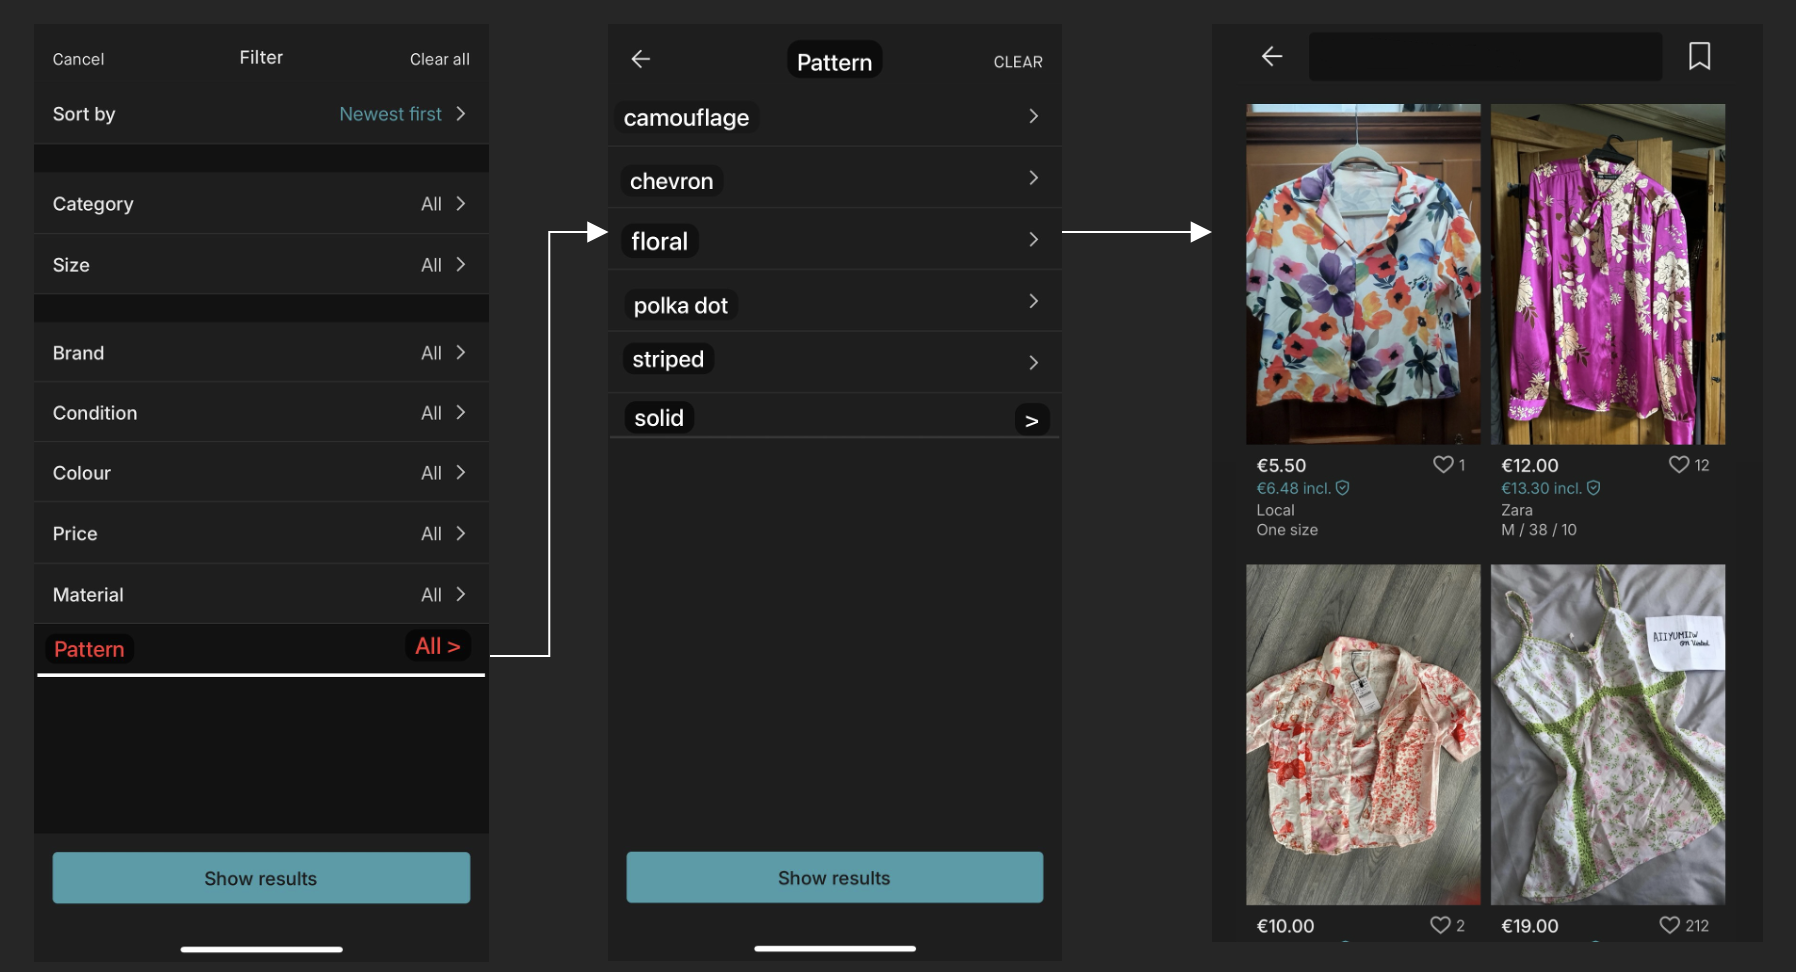

In [6]:
from IPython.display import Image
Image(filename="usage_example.png")

**B. Dataset processing:**
**Exploration of the dataset and preparation for model building.**

B.1. Importing the relevant libraries and modules, conversion of all the files to JPG, to unify their format and because JPG performs better for photorealistic images.

In [10]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pyarrow.parquet as pq


from PIL import Image
from os import listdir
from os.path import splitext, join
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import layers, models
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
target_directory = 'Data Science intern, Buyer/photo_dataset_for_HW_task/'
target_format = '.jpg'

for file in listdir(target_directory):
    filename, extension = splitext(file)
    try:
        if extension.lower() not in ['.py', target_format]:
            image_path = join(target_directory, file)
            im = Image.open(image_path)
            target_path = join(target_directory, filename + target_format)
            im.save(target_path)
            print(f"Converted {file} to {filename}{target_format}")
    except OSError:
        print('Cannot convert %s' % file)

Converted 3975.png to 3975.jpg
Converted 348.png to 348.jpg
Converted 689.jpeg to 689.jpg
Converted 1804.png to 1804.jpg
Converted 373.jpeg to 373.jpg
Converted 4144.jpeg to 4144.jpg
Converted 4968.png to 4968.jpg
Converted 1810.png to 1810.jpg
Converted 6819.png to 6819.jpg
Converted 1186.png to 1186.jpg
Converted 412.png to 412.jpg
Converted 3949.png to 3949.jpg
Converted 3791.png to 3791.jpg
Converted 4798.png to 4798.jpg
Converted 4940.png to 4940.jpg
Converted 4902.jpeg to 4902.jpg
Converted 5486.png to 5486.jpg
Converted 374.png to 374.jpg
Converted 1838.png to 1838.jpg
Converted 7291.png to 7291.jpg
Converted 360.png to 360.jpg
Converted 5492.png to 5492.jpg
Converted 3785.png to 3785.jpg
Converted 6825.png to 6825.jpg
Converted 406.png to 406.jpg
Converted 1192.png to 1192.jpg
Converted 1179.png to 1179.jpg
Converted 6616.png to 6616.jpg
Converted 4001.png to 4001.jpg
Converted 2470.png to 2470.jpg
Converted 3814.jpeg to 3814.jpg
Converted 1829.jpeg to 1829.jpg
Converted 2316.p

B.2. Reading the dataset into pandas, retaining only the relevant columns for the task, and removing NaN values.

In [60]:
file_route = 'Data Science intern, Buyer/dataset_for_HW_task.parquet'

table = pq.read_table(file_route)
df = table.to_pandas()

display(df)

uuid  days_to_sell   gmv_eur catalog_code_1      catalog_code_2  \
0        0           NaN       NaN     WOMEN_ROOT              WOMENS   
1        1           1.0  1.482800     WOMEN_ROOT              WOMENS   
2        2           NaN       NaN     WOMEN_ROOT              WOMENS   
3        3          42.0  2.322476     WOMEN_ROOT              WOMENS   
4        4           1.0  8.000000           MENS        MEN_CLOTHING   
...    ...           ...       ...            ...                 ...   
7386  7386           1.0  1.000000     WOMEN_ROOT              WOMENS   
7387  7387           3.0  1.756029     WOMEN_ROOT              WOMENS   
7388  7388           NaN       NaN     WOMEN_ROOT              WOMENS   
7389  7389           NaN       NaN   CHILDREN_NEW  TOYS_AND_GAMES_NEW   
7390  7390          19.0  5.000000     WOMEN_ROOT              WOMENS   

           catalog_code_3   catalog_code_4                catalog_code_5  \
0                 DRESSES   SUMMER_DRESSES                          None   
1                 DRESSES   CASUAL_DRESSES                          None   
2           TOPS_T_SHIRTS           SHIRTS                          None   
3           TOPS_T_SHIRTS          BLOUSES                          None   
4       MEN_OUTERWEAR_NEW      MEN_JACKETS  MEN_MILITARY_UTILITY_JACKETS   
...                   ...              ...                           ...   
7386             TROUSERS  SKINNY_TROUSERS                          None   
7387              DRESSES   SUMMER_DRESSES                          None   
7388        TOPS_T_SHIRTS          BLOUSES                          None   
7389  STUFFED_ANIMALS_NEW             None                          None   
7390               SKIRTS      MINI_SKIRTS                          None   

       pattern_tag   filename  
0        [striped]     0.jpeg  
1         [floral]      1.png  
2          [solid]     2.jpeg  
3         [floral]      3.png  
4          [solid]      4.png  
...            ...        ...  
7386       [solid]   7386.png  
7387      [floral]   7387.png  
7388            []  7388.jpeg  
7389     [striped]   7389.png  
7390  [camouflage]   7390.png  

[7391 rows x 10 columns]

In [67]:
import pandas as pd

items = df['catalog_code_3'].unique()
items_list = items.tolist()
print("Possible values in catalog_code_3:", items_list)

# After manual inspection, we remove the items that are not clothes
non_textile_categories = [
    'JEWELRY', 'STUFFED_ANIMALS_NEW', 'H_TAPESTRIES_WALL_HANGINGS',
    'H_BOOKS_KIDS_YOUNG_ADULTS', 'H_TABLE_LINEN', 'H_CUSHIONS', 
    'H_VASES', 'H_DRINKWARE', 'NON_FICTION', 'SCHOOL_SUPPLIES_NEW', 
    'H_BOOKS_NON_FICTION', 'KIDS_DISHES_NEW', 'H_FRAMES', 
    'H_STORAGE', 'DIAPERING_AND_CARING_NEW', 'ACCESS_MOBILE', 
    'H_CANDLES_CANDLE_HOLDERS', 'H_TOWELS', 'H_BEDDING', 
    'BABY_CARRIERS_AND_WRAPS_NEW', 'SUNGLASSES', 'WATCHES', 
    'SCHOOL_BAGS_NEW', 'H_HOLDALLS', 'TOTE_BAGS', 'PURSES', 
    'BAGS', 'H_COSMETICS', 'H_UTENSILS', 'H_MOBILE_ACCESSORIES', 
    'H_FURNITURE', 'H_MEN_ACCESSORIES', 'H_OTHER_ACCESSORIES', 
    'H_OTHERS'
]

df_filtered = df[~df['catalog_code_3'].isin(non_textile_categories)]
new_names = {'pattern_tag': 'pattern'}
df_filtered = df_filtered.rename(columns=new_names)
df_filtered = df_filtered[['pattern', 'filename']]
df_filtered['filename'] = df_filtered['filename'].str.replace('.png', '.jpg')
df_filtered = df_filtered.explode('pattern')
df = df_filtered.dropna()
df.reset_index(drop=True, inplace=True)

display(df)


Possible values in catalog_code_3: ['DRESSES', 'TOPS_T_SHIRTS', 'MEN_OUTERWEAR_NEW', 'SPECIALISED_CLOTHING_COSTUMES', 'BOYS_COATS', 'TROUSERS', 'JEANS', 'PULLOVERS_SWEATERS', 'W_TRAINERS', 'BLAZERS', 'MEN_TOPS_T_SHIRTS', 'JEWELRY', 'SKIRTS', 'MEN_OTHER', 'GIRLS_SHIRTS', 'BOYS_SWEATERS', 'COATS_JACKETS', 'MEN_TROUSERS', 'JUMPSUITS_UK', 'MEN_PULLOVERS_SWEATERS', 'SWIMWEAR', 'GIRLS_COATS', 'GIRLS_DRESSES', 'SHORTS_CAPRIS', 'BOYS_SWIMWEAR', 'BOYS_PANTS', 'OTHER_CLOTHES', 'GIRLS_SWEATERS', 'BOYS_SHIRTS', 'SPORTSWEAR', 'SPORTSWEAR_WOMEN', 'GIRLS_PANTS', 'STUFFED_ANIMALS_NEW', 'GIRLS_BABIES', 'SPORT_SHOES_MEN', 'BOYS_OTHER', 'APPAREL', 'BOYS_SWIM', 'TWINS_BOYS_NEW', 'MEN_TRO_JEANS', 'GIRLS_SKIRTS', 'W_FLATS_MAIN', 'BOYS_BABIES', 'H_TAPESTRIES_WALL_HANGINGS', 'WOMEN_BANDANAS_HEADSCARVES', 'THEMED_COSTUMES_NEW', 'WOM_ACC_SCARVES_SHAWLS', 'GIRLS_SWIM', 'H_BLANKETS', 'W_OTHER_ACCESSORIES', 'LINGERIE', 'SLEEPING_ACCESSORIES_NEW', 'SUITS_BLAZERS', 'HANDBAGS', 'SLIPPERS', 'GIRLS_OTHER', 'PURSES', 'M

pattern  filename
0        striped    0.jpeg
1         floral     1.jpg
2          solid    2.jpeg
3         floral     3.jpg
4          solid     4.jpg
...          ...       ...
6844   polka_dot  7383.jpg
6845      floral  7384.jpg
6846       solid  7386.jpg
6847      floral  7387.jpg
6848  camouflage  7390.jpg

[6849 rows x 2 columns]

B.3. Encoding the categorical column "pattern" using LabelEncoder, converting it to binary categorical format.

In [68]:
categorical_target = ['pattern']
categorical_target_encoders = []

le_dico = {}
for item in categorical_target:
    le = LabelEncoder()
    le.fit(df[item])
    df[item+'_le'] = le.transform(df[item])
    categorical_target_encoders.append(le)
    le_dico[item] = le

dd = to_categorical(df['pattern_le'], num_classes=len(le.classes_)).astype(int)
columns_pattern = [x.lower() for x in le.inverse_transform(range(len(le.classes_)))]

dd_pd = pd.DataFrame(dd, columns=columns_pattern, index=df.index)
df = pd.concat([df.drop('pattern_le', axis=1), dd_pd], axis=1)

df['filename'] = df['filename'].astype(str).str.replace('.png', '.jpeg')

display(df)

/var/folders/m5/hx6kf9md25d1tjdx2zjb26180000gn/T/ipykernel_10465/754079955.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[item+'_le'] = le.transform(df[item])


pattern  filename  camouflage  chevron  floral  polka_dot  solid  \
0        striped    0.jpeg           0        0       0          0      0   
1         floral     1.jpg           0        0       1          0      0   
2          solid    2.jpeg           0        0       0          0      1   
3         floral     3.jpg           0        0       1          0      0   
4          solid     4.jpg           0        0       0          0      1   
...          ...       ...         ...      ...     ...        ...    ...   
6844   polka_dot  7383.jpg           0        0       0          1      0   
6845      floral  7384.jpg           0        0       1          0      0   
6846       solid  7386.jpg           0        0       0          0      1   
6847      floral  7387.jpg           0        0       1          0      0   
6848  camouflage  7390.jpg           1        0       0          0      0   

      striped  
0           1  
1           0  
2           0  
3           0  
4           0  
...       ...  
6844        0  
6845        0  
6846        0  
6847        0  
6848        0  

[6849 rows x 8 columns]

B.4. Loading images from a specified folder, resizing them, converting them into numpy arrays, and saving them into `.npy` files. Additionally, extracting labels from the DataFrame and saving them into a separate `.npy` file.

In [86]:
import os
import numpy as np
from PIL import Image

data_folder = 'Data Science intern, Buyer/photo_dataset_for_HW_task'

image_data = []
labels = []

for index, row in df.iterrows():
    image_title = row['filename']
    label = row.drop(['filename', 'pattern'], axis=0)
    image_path = os.path.join(data_folder, image_title)

    if os.path.exists(image_path):
        try:
            with Image.open(image_path) as image:
                if image:
                    im = image.resize((120, 150), Image.LANCZOS)
                    image_data.append(np.array(im))
                    labels.append(label)
        except Exception as e:
            print(f"Error opening image '{image_path}': {e}")

# Convert labels to array after filtering
tr_labels = np.array(labels)
image_matrix = np.array(image_data)

# Save data and labels in .npy files
np.save("Data Science intern, Buyer/data.npy", image_matrix)
np.save("Data Science intern, Buyer/labels.npy", tr_labels)

print(f"Number of images: {len(image_data)}")
print(f"Number of labels: {len(labels)}")


Number of images: 6849
Number of labels: 6849


B.5. Showing some image examples.

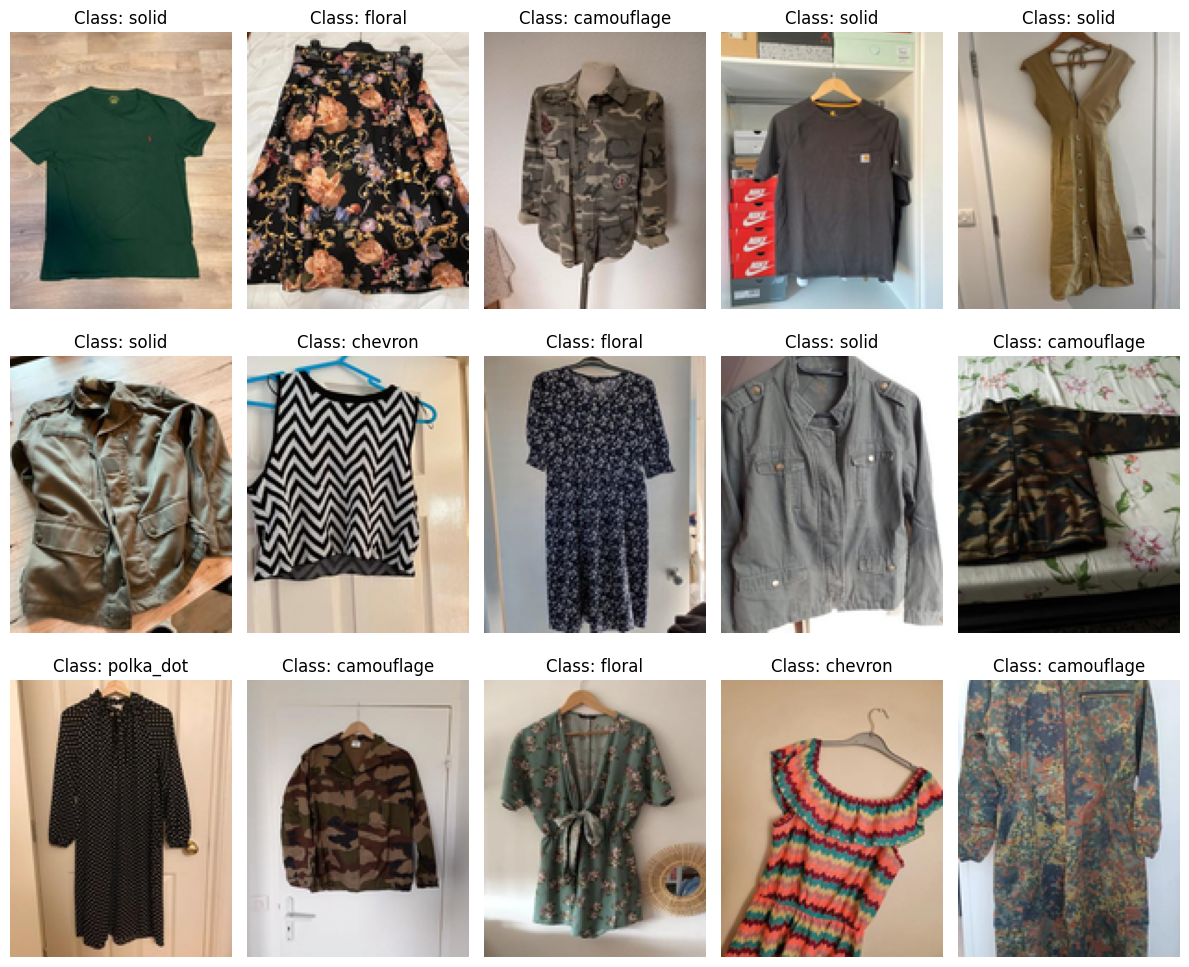

In [87]:
import random
import matplotlib.pyplot as plt

# Define the number of samples to select
num_samples = 15

if len(image_data) == 0 or len(labels) == 0:
    print("No images or labels available to display.")
else:
    random_indices = random.sample(range(len(image_data)), min(num_samples, len(image_data)))

    # Create a grid to display the selected samples
    plt.figure(figsize=(12, 10))

    le = le_dico['pattern']

    for i, index in enumerate(random_indices):
        example_image = image_data[index]
        example_label = labels[index]

        class_index = np.argmax(example_label)
        original_label = le.inverse_transform([class_index])[0]

        plt.subplot(3, 5, i + 1)
        plt.imshow(example_image)
        plt.title(f'Class: {original_label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [90]:
# Loading data from the directory.
file_dir = "Data Science intern, Buyer/"
data = np.load(file_dir + "data.npy")
labels = np.load(file_dir + "labels.npy", allow_pickle=True)
class_labels = np.argmax(labels, axis=1)

B.5. Setting random seeds to ensure reproducibility, splitting the dataset into training and test sets (80-20 split), maintaining stratified sampling. Training set is further divided into training and validation sets (60-20 split), also preserving stratification. Normalizing image data  by dividing pixel values by 255 to scale them to the range [0,1] and converting target labels to float type. Defining all possible class labels, counting the number of samples for each class in the entire dataset and mpping class labels to their corresponding names.

In [91]:
# Set random seed
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Split the training and test sets (80% training, 20% testing) while maintaining stratified sampling and a random seed
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=class_labels)

# Split the training set into training and validation sets (60% training, 20% validation) while preserving stratified sampling and a random seed
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Normalize image data
X_train_normalized = X_train / 255.0
X_val_normalized = X_val / 255.0
X_test_normalized = X_test / 255.0

# Convert target labels to floats
y_train_float = y_train.astype(float)
y_val_float = y_val.astype(float)
y_test_float = y_test.astype(float)

Forma de y_train_float: (4383, 6)
Forma de y_val_float: (1096, 6)
Forma de y_test_float: (1370, 6)


In [92]:
# Define all possible class labels
all_class_labels = ['camouflage','chevron','floral','polka_dot','solid','striped']

# Count the number of samples for each class in the entire dataset
class_labels_unique, class_counts = np.unique(np.argmax(labels, axis=1), return_counts=True)

# Counting number of classes
num_classes = len(class_labels_unique)

# Map class labels to their corresponding names
class_names = [all_class_labels[label] for label in class_labels_unique]

B.6. This code segment analyzes the distribution of class labels across the entire dataset and its subsets (training, validation, and test sets). It first defines all possible class labels and then counts the number of samples for each class in the entire dataset, as well as in each subset. It creates a 2x2 grid of subplots to visualize the class label distribution, where each subplot displays a bar chart representing the number of samples for each class. The x-axis represents the class labels, while the y-axis represents the number of samples. The bars are labeled with their respective sample counts. This visualization helps understand the distribution of data across different classes and subsets, providing insights into the dataset's composition and potential biases.

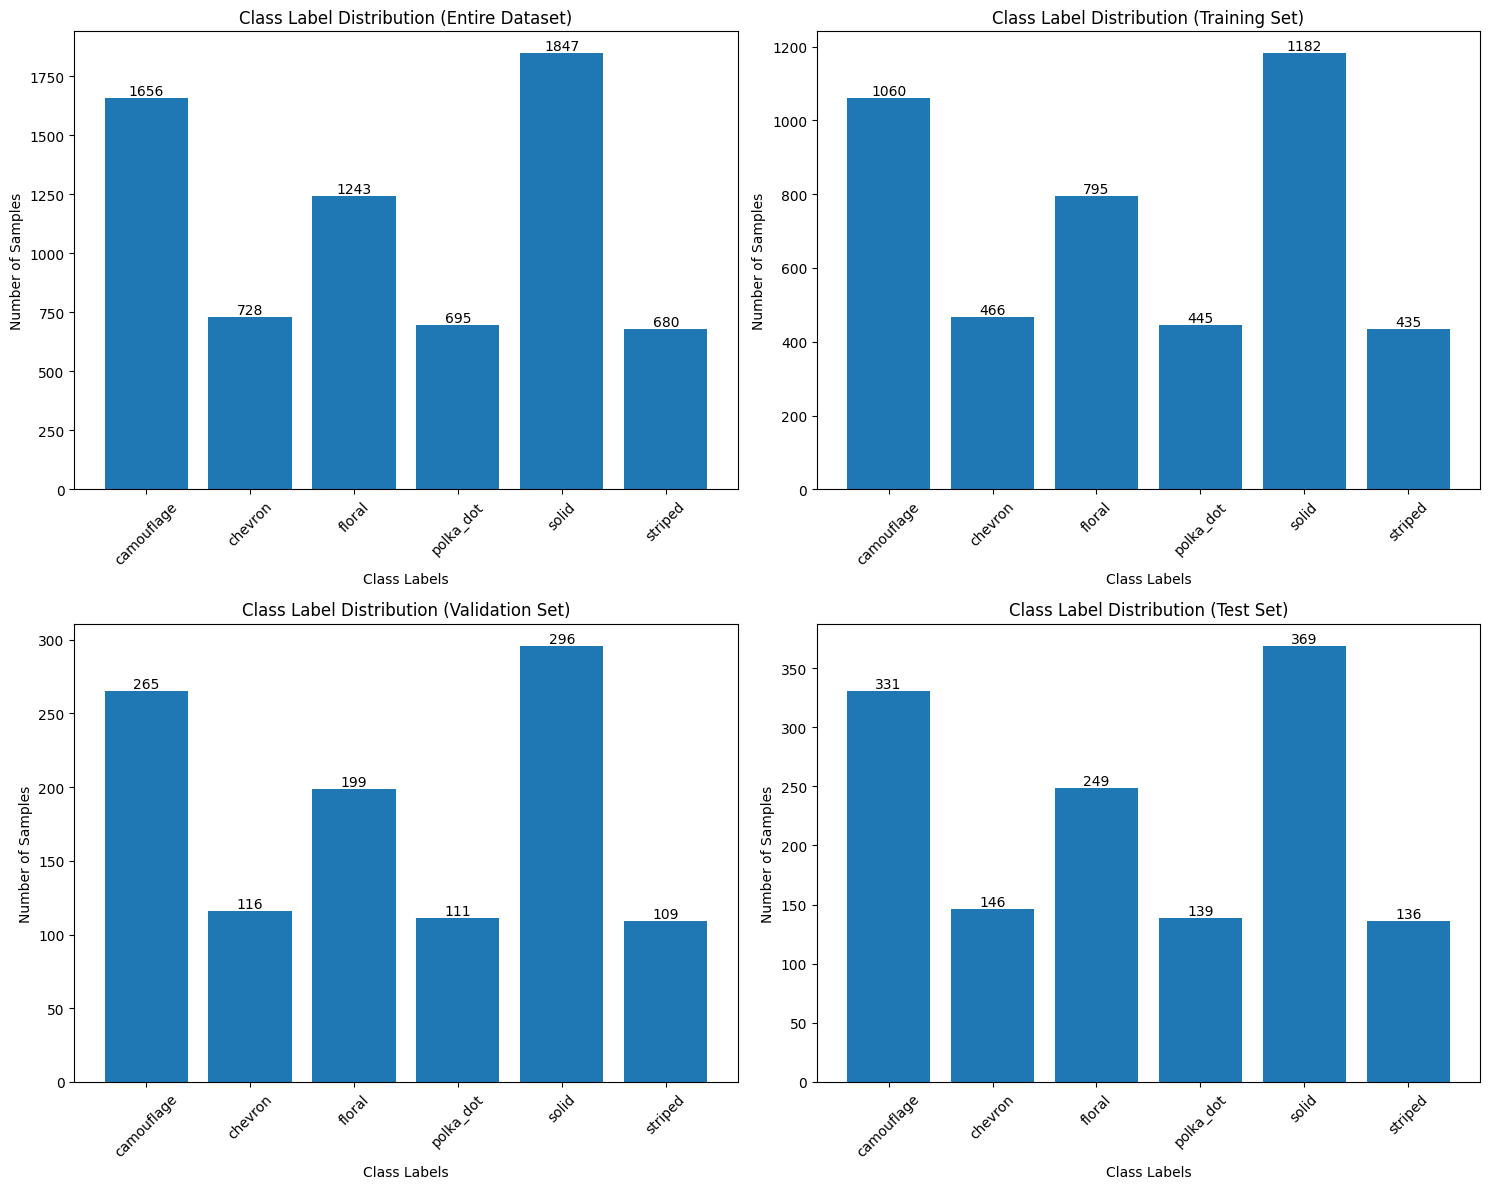

In [93]:
def adjust_class_counts(class_labels, class_counts, all_class_labels):
    # Dictionary to count the classes
    count_dict = dict(zip(class_labels, class_counts))
    adjusted_counts = [count_dict.get(label, 0) for label in all_class_labels]
    
    return adjusted_counts

# Adjust the counts to make sure the classes match
train_class_counts = adjust_class_counts(all_class_labels, np.sum(y_train, axis=0), all_class_labels)
val_class_counts = adjust_class_counts(all_class_labels, np.sum(y_val, axis=0), all_class_labels)
test_class_counts = adjust_class_counts(all_class_labels, np.sum(y_test, axis=0), all_class_labels)

# Create subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot class label distribution for the entire dataset
axes[0, 0].bar(all_class_labels, class_counts)
axes[0, 0].set_xlabel('Class Labels')
axes[0, 0].set_ylabel('Number of Samples')
axes[0, 0].set_title('Class Label Distribution (Entire Dataset)')
axes[0, 0].tick_params(axis='x', rotation=45, labelrotation=45)  
for i, v in enumerate(class_counts):
    axes[0, 0].text(i, v, str(v), ha='center', va='bottom', fontsize=10)

# Plot class label distribution for the training set
axes[0, 1].bar(all_class_labels, train_class_counts)
axes[0, 1].set_xlabel('Class Labels')
axes[0, 1].set_ylabel('Number of Samples')
axes[0, 1].set_title('Class Label Distribution (Training Set)')
axes[0, 1].tick_params(axis='x', rotation=45, labelrotation=45)  
for i, v in enumerate(train_class_counts):
    axes[0, 1].text(i, v, str(v), ha='center', va='bottom', fontsize=10)

# Plot class label distribution for the validation set
axes[1, 0].bar(all_class_labels, val_class_counts)
axes[1, 0].set_xlabel('Class Labels')
axes[1, 0].set_ylabel('Number of Samples')
axes[1, 0].set_title('Class Label Distribution (Validation Set)')
axes[1, 0].tick_params(axis='x', rotation=45, labelrotation=45)  
for i, v in enumerate(val_class_counts):
    axes[1, 0].text(i, v, str(v), ha='center', va='bottom', fontsize=10)

# Plot class label distribution for the test set
axes[1, 1].bar(all_class_labels, test_class_counts)
axes[1, 1].set_xlabel('Class Labels')
axes[1, 1].set_ylabel('Number of Samples')
axes[1, 1].set_title('Class Label Distribution (Test Set)')
axes[1, 1].tick_params(axis='x', rotation=45, labelrotation=45)  
for i, v in enumerate(test_class_counts):
    axes[1, 1].text(i, v, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


**C. Model development**

C.1. Definition of the Convolutional Neural Network (CNN) model architecture using the Keras Sequential API. This includes several convolutional layers followed by max-pooling layers for feature extraction from input images. The flattened output is passed through dense layers for classification, with the final output layer using softmax activation for multiclass classification. The model is compiled with the Adam optimizer and categorical crossentropy loss function. After defining the model, hyperparameters such as the number of epochs and batch size are set, and the model is trained on the training data. Training progress is displayed, and the model's performance is evaluated on the test set, with test loss and accuracy printed.

CNNs is the chosen architecture as they are powerful for image classification due to their ability to automatically learn relevant features, efficiency in handling large datasets, and capability to transfer knowledge from related tasks.

In [96]:
# Define the CNN model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(150, 120, 3), name='conv2d'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_1'))
model.add(layers.MaxPooling2D((2, 2), name='max_pooling2d'))

# Repeat the block of convolutional layers followed by max pooling
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_2'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_3'))
model.add(layers.MaxPooling2D((2, 2), name='max_pooling2d_1'))

# Flatten the output before the dense layers
model.add(layers.Flatten(name='flatten'))

# Dense layers
model.add(layers.Dense(32, activation='relu', name='dense'))
model.add(layers.Dense(32, activation='relu', name='dense_1'))

# Output layer with proper number of classes
model.add(layers.Dense(6, activation='softmax', name='dense_2'))  # num_classes should be 18, not 6

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Hyperparameter settings
epochs = 8  # Number of training epochs
batch_size = 16  # Batch size for training

# Model training
history = model.fit(
    X_train_normalized,  # Training data features
    y_train_float,       # Training data labels
    epochs=epochs,       # Number of training epochs
    batch_size=batch_size,  # Batch size
    validation_data=(X_val_normalized, y_val_float),  # Validation data
    verbose=1            # Set to 1 to display training progress
)

# Print the model's loss and accuracy on the test set
test_loss, test_accuracy = model.evaluate(X_test_normalized, y_test_float, verbose=0)
print(f"Test Loss: {test_loss:.4f}")  
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")  


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 120, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 120, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 60, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 35520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,136,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,195,142 (4.56 MB)

 Trainable params: 1,195,142 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 84s 306ms/step - accuracy: 0.3133 - loss: 1.6500 - val_accuracy: 0.4316 - val_loss: 1.4526
Epoch 2/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 94s 343ms/step - accuracy: 0.4862 - loss: 1.3626 - val_accuracy: 0.5611 - val_loss: 1.2058
Epoch 3/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 126s 460ms/step - accuracy: 0.6138 - loss: 1.0614 - val_accuracy: 0.6515 - val_loss: 1.0366
Epoch 4/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 112s 407ms/step - accuracy: 0.6667 - loss: 0.9049 - val_accuracy: 0.6588 - val_loss: 1.0938
Epoch 5/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 114s 416ms/step - accuracy: 0.7040 - loss: 0.8000 - val_accuracy: 0.6880 - val_loss: 1.0279
Epoch 6/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 113s 411ms/step - accuracy: 0.7602 - loss: 0.6675 - val_accuracy: 0.6560 - val_loss: 1.1810
Epoch 7/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 112s 409ms/step - accuracy: 0.8113 - loss: 0.5289 - val_accuracy: 0.6369 - val_loss: 1.4045
Epoch 8/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 115s 419ms/step - accuracy: 0.8621 - loss: 0.3

C.2. Analyzing the performance of the baseline model. Firstly, we plot the training and validation accuracies over epochs on the left subplot. Then, on the right subplot, we plot the training and validation losses over epochs. The plots help visualize how the model's accuracy and loss change during the training process, providing insights into the model's performance and potential areas for improvement. Finally, we format the y-axis to display values with two decimal places and display the plots using Matplotlib.

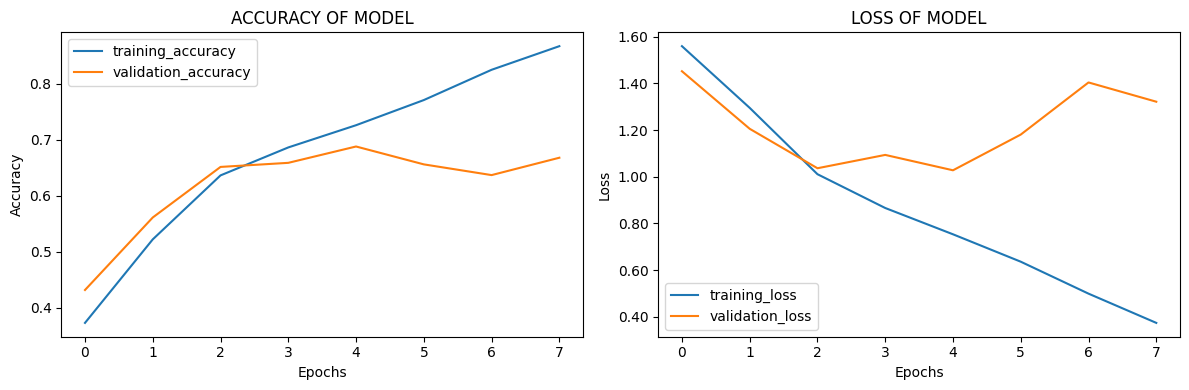

In [97]:
# # Baseline Model Analysis

# Plot training and validation accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ACCURACY OF MODEL')  

# Plot training and validation losses
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LOSS OF MODEL')  

# Format y-axis to display two decimal places
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)

plt.tight_layout()
plt.show()

C.3. This code segment is for computing the Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) scores for the validation set. First, it predicts the probabilities for each class using the trained model on the validation data. Then, it calculates the ROC curve and AUC score for each class separately. Additionally, it computes the micro-average ROC curve and AUC score, which aggregates all the true positives and false positives across classes. Similarly, it calculates the macro-average ROC curve and AUC score, which averages the true positive rates of each class. Finally, it plots the micro-average and macro-average ROC curves, along with individual ROC curves for each class, showing the AUC scores in the legend. The plot provides insights into the model's performance in distinguishing between different classes.

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step


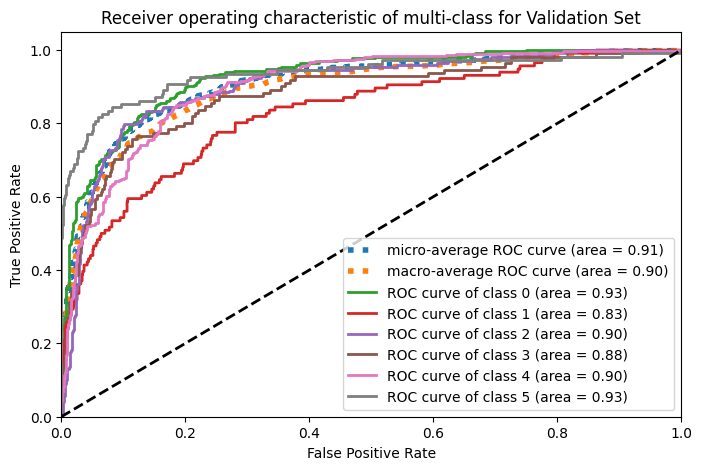

In [98]:
# ROC curve and AUC score for validation set
y_pred_val = model.predict(X_val_normalized)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_float[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_val_float.ravel(), y_pred_val.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
roc_auc_macro = auc(all_fpr, mean_tpr)

# Create a figure and axis for plotting
plt.figure(figsize=(8, 5))
plt.plot(fpr_micro, tpr_micro, label=f'micro-average ROC curve (area = {roc_auc_micro:.2f})', linestyle=':', linewidth=4)
plt.plot(all_fpr, mean_tpr, label=f'macro-average ROC curve (area = {roc_auc_macro:.2f})', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

# Set plot properties
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of multi-class for Validation Set')
plt.legend(loc='lower right')
plt.show()


C.4. Evaluation the performance of a trained model on the validation set by generating a confusion matrix. First, obtaining the predicted labels from the model's output probabilities for the validation data and computes the confusion matrix, which depicts the model's classification accuracy. Then, visualizing the confusion matrix as a heatmap using Seaborn, annotating the matrix with the count of true positives, false positives, true negatives, and false negatives for each class. This visualization provides insights into the model's ability to correctly classify different classes, helping to identify any misclassifications or areas of improvement.

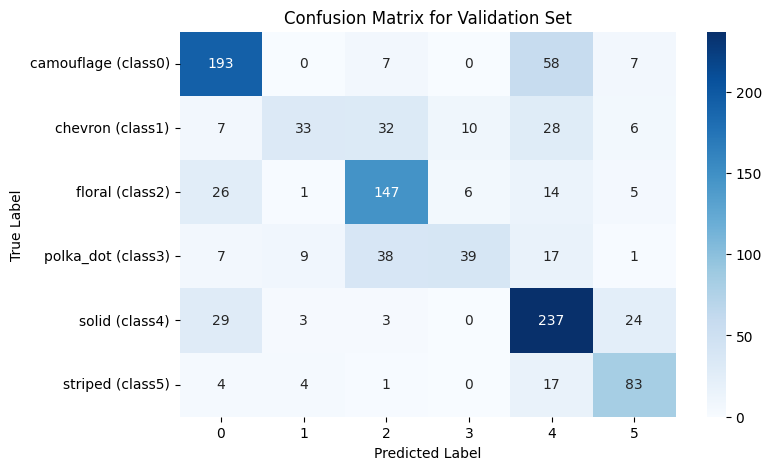

In [99]:
# Get predicted labels for validation set
y_pred_val_labels = np.argmax(y_pred_val, axis=1)

# Create a confusion matrix
confusion_mat_val = confusion_matrix(np.argmax(y_val_float, axis=1), y_pred_val_labels)

# Create a figure for the confusion matrix
plt.figure(figsize=(8, 5))

# Create a heatmap for the confusion matrix
sns.heatmap(confusion_mat_val, annot=True, fmt='d', cmap='Blues', cbar=True)

# Set plot properties
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Set')
plt.xticks(ticks=np.arange(len(all_class_labels)) + 0.5, labels=np.arange(0, len(all_class_labels)), rotation=0)
plt.yticks(ticks=np.arange(len(all_class_labels)) + 0.5, labels=[f'{label} (class{i})' for i, label in enumerate(all_class_labels)], rotation=0)
plt.show()

C.5. Generating a classification report.

In [100]:
# Generate a classification report
class_report_val = classification_report(np.argmax(y_val_float, axis=1), y_pred_val_labels, target_names=[f'{label} (class {i})' for i, label in enumerate(all_class_labels)])

# Calculate specificity, sensitivity, and F1-score
TN = confusion_mat_val[0, 0]
FP = confusion_mat_val[0, 1]
FN = confusion_mat_val[1, 0]
TP = confusion_mat_val[1, 1]

specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)
f1_score = 2 * (sensitivity * specificity) / (sensitivity + specificity)

# Calculate accuracy
accuracy = accuracy_score(np.argmax(y_val_float, axis=1), y_pred_val_labels)

# Print the classification report along with specificity, sensitivity, and F1-score for the validation set
print("Classification Report (Validation Set):\n", class_report_val)
print(f"Accuracy (Validation Set): {accuracy:.2f}")
print(f"Specificity (Validation Set): {specificity:.2f}")
print(f"Sensitivity (Validation Set): {sensitivity:.2f}")
print(f"F1-Score (Validation Set): {f1_score:.2f}")


Classification Report (Validation Set):
                       precision    recall  f1-score   support

camouflage (class 0)       0.73      0.73      0.73       265
   chevron (class 1)       0.66      0.28      0.40       116
    floral (class 2)       0.64      0.74      0.69       199
 polka_dot (class 3)       0.71      0.35      0.47       111
     solid (class 4)       0.64      0.80      0.71       296
   striped (class 5)       0.66      0.76      0.71       109

            accuracy                           0.67      1096
           macro avg       0.67      0.61      0.62      1096
        weighted avg       0.67      0.67      0.65      1096

Accuracy (Validation Set): 0.67
Specificity (Validation Set): 1.00
Sensitivity (Validation Set): 0.82
F1-Score (Validation Set): 0.90


C.6. Evaluation on the test set.

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step


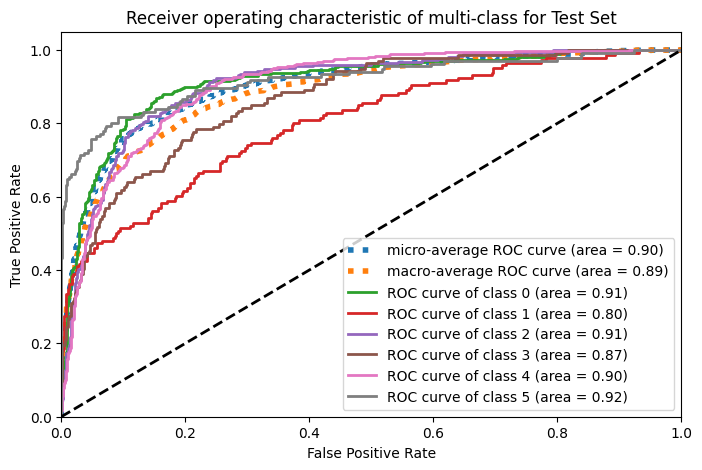

In [101]:
# ROC curve and AUC score for test set
y_pred_test = model.predict(X_test_normalized)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_float[:, i], y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_float.ravel(), y_pred_test.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
roc_auc_macro = auc(all_fpr, mean_tpr)

# Create a figure and axis for plotting
plt.figure(figsize=(8, 5))
plt.plot(fpr_micro, tpr_micro, label=f'micro-average ROC curve (area = {roc_auc_micro:.2f})', linestyle=':', linewidth=4)
plt.plot(all_fpr, mean_tpr, label=f'macro-average ROC curve (area = {roc_auc_macro:.2f})', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

# Set plot properties
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of multi-class for Test Set')
plt.legend(loc='lower right')
plt.show()

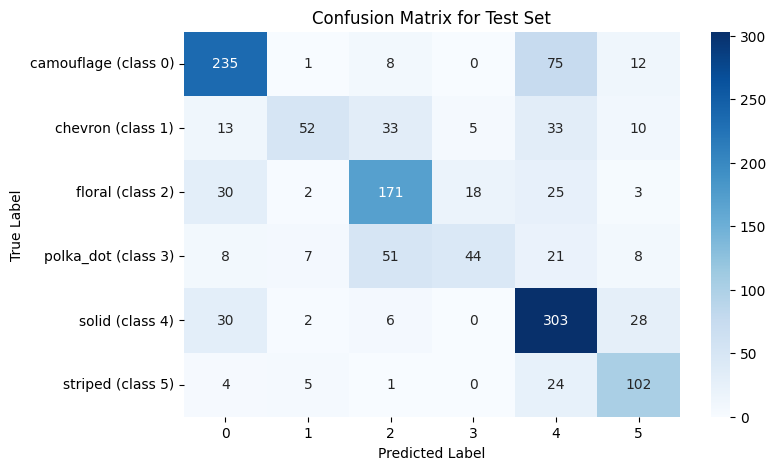

Classification Report (Test Set):
                       precision    recall  f1-score   support

camouflage (class 0)       0.73      0.71      0.72       331
   chevron (class 1)       0.75      0.36      0.48       146
    floral (class 2)       0.63      0.69      0.66       249
 polka_dot (class 3)       0.66      0.32      0.43       139
     solid (class 4)       0.63      0.82      0.71       369
   striped (class 5)       0.63      0.75      0.68       136

            accuracy                           0.66      1370
           macro avg       0.67      0.61      0.61      1370
        weighted avg       0.67      0.66      0.65      1370

Accuracy (Test Set): 0.66
Specificity (Test Set): 1.00
Sensitivity (Test Set): 0.80
F1-Score (Test Set): 0.89


In [102]:
# Get predicted labels for test set
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

# Create a confusion matrix for the test set
confusion_mat_test = confusion_matrix(np.argmax(y_test_float, axis=1), y_pred_test_labels)

# Create a figure for the confusion matrix
plt.figure(figsize=(8, 5))

# Create a heatmap for the confusion matrix
sns.heatmap(confusion_mat_test, annot=True, fmt='d', cmap='Blues', cbar=True)

# Set plot properties
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.xticks(ticks=np.arange(len(all_class_labels)) + 0.5, labels=np.arange(len(all_class_labels)), rotation=0)
plt.yticks(ticks=np.arange(len(all_class_labels)) + 0.5, labels=[f'{label} (class {i})' for i, label in enumerate(all_class_labels)], rotation=0)
plt.show()

# Generate a classification report
class_report_test = classification_report(np.argmax(y_test_float, axis=1), y_pred_test_labels, target_names=[f'{label} (class {i})' for i, label in enumerate(all_class_labels)])

# Calculate specificity, sensitivity, and F1-score for the test set
TN = confusion_mat_test[0, 0]
FP = confusion_mat_test[0, 1]
FN = confusion_mat_test[1, 0]
TP = confusion_mat_test[1, 1]

specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)
f1_score = 2 * (sensitivity * specificity) / (sensitivity + specificity)

# Calculate accuracy for the test set
accuracy = accuracy_score(np.argmax(y_test_float, axis=1), y_pred_test_labels)

# Print the classification report along with specificity, sensitivity, and F1-score for the test set
print("Classification Report (Test Set):\n", class_report_test)
print(f"Accuracy (Test Set): {accuracy:.2f}")
print(f"Specificity (Test Set): {specificity:.2f}")
print(f"Sensitivity (Test Set): {sensitivity:.2f}")
print(f"F1-Score (Test Set): {f1_score:.2f}")

C.7. Implementation of an enhanced model training process using data augmentation techniques. First, an ImageDataGenerator object is created with various augmentation parameters such as rotation range, width and height shift range, shear range, zoom range, and horizontal flip. This generator is configured to apply these augmentation techniques to the training images. The fit() method is then used to fit the data generator to the training data, which calculates the necessary statistics to perform data augmentation. Next, the fit() method is used again to train the model, but this time, it takes the augmented data generated by the datagen.flow() method as input. During training, the model learns from both the original and augmented data, helping to improve its generalization and robustness by exposing it to a wider range of variations in the training data. The validation data remains unchanged, ensuring that the model's performance is evaluated on original, unaltered data.

In [105]:
# ## Enhanced Model
# Create an image data generator with various data augmentation techniques
datagen = ImageDataGenerator(
    rotation_range=20,            # Rotation range for random rotations (degrees)
    width_shift_range=0.2,        # Fraction of total width to shift horizontally
    height_shift_range=0.2,       # Fraction of total height to shift vertically
    shear_range=0.2,              # Shear intensity (shear angle in radians)
    zoom_range=0.2,               # Range for random zoom
    horizontal_flip=True,         # Randomly flip inputs horizontally
    fill_mode='nearest'           # Strategy for filling in newly created pixels
)

# Apply data augmentation to the training dataset
datagen.fit(X_train_normalized)

# Train the model using augmented data
history = model.fit(
    datagen.flow(X_train_normalized, y_train_float, batch_size=batch_size),  # Flow augmented data in batches
    epochs=epochs,               # Number of training epochs
    validation_data=(X_val_normalized, y_val_float),  # Validation data
    verbose=1
)


Epoch 1/8


/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


274/274 ━━━━━━━━━━━━━━━━━━━━ 84s 306ms/step - accuracy: 0.7597 - loss: 0.7182 - val_accuracy: 0.6980 - val_loss: 1.1716
Epoch 2/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 99s 360ms/step - accuracy: 0.7541 - loss: 0.7055 - val_accuracy: 0.7327 - val_loss: 0.8354
Epoch 3/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 110s 399ms/step - accuracy: 0.7704 - loss: 0.6702 - val_accuracy: 0.6487 - val_loss: 1.0809
Epoch 4/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 106s 387ms/step - accuracy: 0.7734 - loss: 0.6598 - val_accuracy: 0.7336 - val_loss: 0.8718
Epoch 5/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 106s 387ms/step - accuracy: 0.7737 - loss: 0.6838 - val_accuracy: 0.7536 - val_loss: 0.8429
Epoch 6/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 111s 405ms/step - accuracy: 0.7840 - loss: 0.6517 - val_accuracy: 0.7619 - val_loss: 0.8611
Epoch 7/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 105s 384ms/step - accuracy: 0.7754 - loss: 0.6517 - val_accuracy: 0.7299 - val_loss: 0.8883
Epoch 8/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 106s 385ms/step - accuracy: 0.7806 - loss: 0.6476 - val_

C.8. Enhanced model analysis.

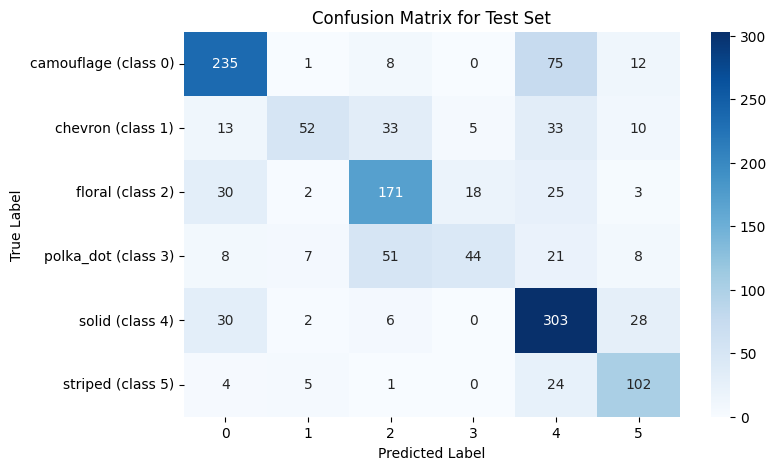

Performance Metrics Report (Test Set):
                       precision    recall  f1-score   support

camouflage (class 0)       0.73      0.71      0.72       331
   chevron (class 1)       0.75      0.36      0.48       146
    floral (class 2)       0.63      0.69      0.66       249
 polka_dot (class 3)       0.66      0.32      0.43       139
     solid (class 4)       0.63      0.82      0.71       369
   striped (class 5)       0.63      0.75      0.68       136

            accuracy                           0.66      1370
           macro avg       0.67      0.61      0.61      1370
        weighted avg       0.67      0.66      0.65      1370

Accuracy (Test Set): 0.66
Specificity (Test Set): 1.00
Sensitivity (Test Set): 0.80
F1-Score (Test Set): 0.89


In [106]:
# Get predicted labels for the test set
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

# Create a confusion matrix
confusion_mat_test = confusion_matrix(np.argmax(y_test_float, axis=1), y_pred_test_labels)

# Create a figure for the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_mat_test, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.xticks(ticks=np.arange(len(all_class_labels)) + 0.5, labels=np.arange(len(all_class_labels)), rotation=0)
plt.yticks(ticks=np.arange(len(all_class_labels)) + 0.5, labels=[f'{label} (class {i})' for i, label in enumerate(all_class_labels)], rotation=0)
plt.show()

# Generate a classification report
class_report_test = classification_report(np.argmax(y_test_float, axis=1), y_pred_test_labels,target_names=[f'{label} (class {i})' for i, label in enumerate(all_class_labels)])

# Calculate specificity, sensitivity, and F1-score
TN = confusion_mat_test[0, 0]
FP = confusion_mat_test[0, 1]
FN = confusion_mat_test[1, 0]
TP = confusion_mat_test[1, 1]

specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)
f1_score = 2 * (sensitivity * specificity) / (sensitivity + specificity)

# Calculate accuracy
accuracy = accuracy_score(np.argmax(y_test_float, axis=1), y_pred_test_labels)

# Print the performance metrics report along with test set accuracy, specificity, sensitivity, and F1-score
print("Performance Metrics Report (Test Set):\n", class_report_test)
print(f"Accuracy (Test Set): {accuracy:.2f}")
print(f"Specificity (Test Set): {specificity:.2f}")
print(f"Sensitivity (Test Set): {sensitivity:.2f}")
print(f"F1-Score (Test Set): {f1_score:.2f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


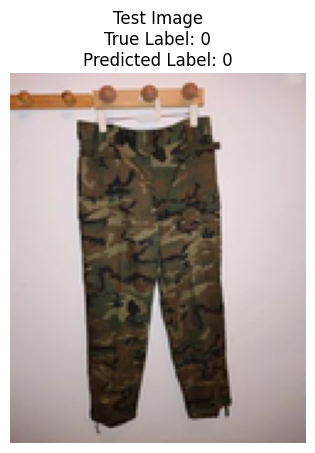

True Label One-Hot Encoding: [1. 0. 0. 0. 0. 0.]
Predicted Label One-Hot Encoding: [9.9515045e-01 2.5373779e-03 1.7663585e-03 1.8586936e-05 4.8978487e-04
 3.7364185e-05]


In [108]:
# Selecting an image and its corresponding label from the test set
index = 357  # Change this index according to your preference
selected_image = X_test_normalized[index]
true_label = y_test_float[index]

# Predicting the label using the trained model
predicted_label = model.predict(np.expand_dims(selected_image, axis=0))[0]

# Converting labels to one-hot encoding
true_label_one_hot = np.argmax(true_label)
predicted_label_one_hot = np.argmax(predicted_label)

# Display the image
plt.imshow(selected_image)
plt.axis('off')
plt.title(f'Test Image\nTrue Label: {true_label_one_hot}\nPredicted Label: {predicted_label_one_hot}')
plt.show()

# Display the one-hot encodings
print(f'True Label One-Hot Encoding: {true_label}')
print(f'Predicted Label One-Hot Encoding: {predicted_label}')

**E. Model performance testing.**

To determine if the model is functioning correctly, it would be beneficial to assess individual instances by uploading various images of clothes that may present challenges for identification. Through a search process, we can verify if the model accurately identifies their patterns. For instance, if we upload an image of a Lacoste floral top and apply filters such as "brand > Lacoste" and "pattern > floral," we can assess whether the piece of clothing is correctly identified. This evaluation should be conducted with diverse images of varying sizes, angles, and colors. A more comprehensive analysis could involve assessing how the model identifies patterns concerning colors, sizes, shapes, and other pattern aspects. For example, does it equally identify green camouflage and red camouflage? Are large dots classified as accurately as small ones? There may be challenging cases to consider. Additionally, soliciting feedback from users or allowing them to report misclassifications, such as encountering a camouflage shirt when searching for floral, can aid in improving the model in the future.